**Описание проекта**

Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Изучение общей информации

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
import matplotlib.pyplot as plt

In [2]:
games = pd.read_csv('/datasets/games.csv')
games.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
12618,3D Lemmings,PS,1995.0,Puzzle,0.03,0.02,0.00,0.00,NaN,NaN,NaN
6602,NASCAR 09,X360,2008.0,Racing,0.23,0.00,0.00,0.02,69.0,7.8,E
52,Gran Turismo,PS,1997.0,Racing,4.02,3.87,2.54,0.52,96.0,8.7,E
13418,Big Air Freestyle,GC,2002.0,Racing,0.04,0.01,0.00,0.00,56.0,tbd,T
7929,Thomas the Tank Engine & Friends,GBA,2004.0,Adventure,0.13,0.05,0.00,0.00,NaN,NaN,NaN


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
games.isna().mean()

Name               0.000120
Platform           0.000000
Year_of_Release    0.016093
Genre              0.000120
NA_sales           0.000000
EU_sales           0.000000
JP_sales           0.000000
Other_sales        0.000000
Critic_Score       0.513192
User_Score         0.400897
Rating             0.404786
dtype: float64

In [5]:
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

**Вывод**

В названии колонок много заглавных букв, и некоторые столбцы называются слишком длинно, исправим.

Видим наличие пропусков в полях:

* название игры - два пропуска,  удалим
* год выпуска - доля составляет менее 2%, удаляем
* много пропусков в оценках и рейтингах - тут ничего не будем делать. Брать среднюю по жанру не вижу логчиным

## Подготовка данных

In [6]:
# Заменим названия столбцов (приведем к нижнему регистру)
games.columns = games.columns.str.lower()
games.rename(columns={"year_of_release":"year","other_sales":"ot_sales"}, inplace = True)
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name            16713 non-null object
platform        16715 non-null object
year            16446 non-null float64
genre           16713 non-null object
na_sales        16715 non-null float64
eu_sales        16715 non-null float64
jp_sales        16715 non-null float64
ot_sales        16715 non-null float64
critic_score    8137 non-null float64
user_score      10014 non-null object
rating          9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [7]:
games.query('name.isna()')

,name,platform,year,genre,na_sales,eu_sales,jp_sales,ot_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [8]:
# удаляем строки
games = games.query('name.notna()')
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name            16713 non-null object
platform        16713 non-null object
year            16444 non-null float64
genre           16713 non-null object
na_sales        16713 non-null float64
eu_sales        16713 non-null float64
jp_sales        16713 non-null float64
ot_sales        16713 non-null float64
critic_score    8137 non-null float64
user_score      10014 non-null object
rating          9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [9]:
# обработка пропусков
games = games.query('year.notna()')


In [10]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name            16444 non-null object
platform        16444 non-null object
year            16444 non-null float64
genre           16444 non-null object
na_sales        16444 non-null float64
eu_sales        16444 non-null float64
jp_sales        16444 non-null float64
ot_sales        16444 non-null float64
critic_score    7983 non-null float64
user_score      9839 non-null object
rating          9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


**Объясним, почему заполнили пропуски определённым образом или почему не стали это делать;**

Год - заполнили пропуски 0, так как данные количественные, удалять их не хочется, так как в них есть полезные данные, например с жанром и количеством продаж

Оценка пользователей, не стали заполнять пропуски на 0, так как потом может повлиять на дальнейший анализ, например на нахождение корреляции между рейтингом пользователей и рейтингом критиков

Рейтинг тоже не трогаем, чтобы потом не было путаницы с категорией рейтингов, например при построении зависимости продаж от рейтинга

Пропуски в оценке критиков не стали заполнять, так как данные не нужны нам для дальнейшего анализа

Обратим внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберем это значение и опишите, как его обработать;


* TBD - Скорее всего имелось ввиду "To be discussed" или "to be determined", что значит "подлежит уточнению/обсуждению. очевидно, что игра перешла необходимый порог пользователей или продаж и в скором времени ожидает присвоение рейтинга. Заменим TBD на 0, чтобы преобразовать столбец с данным рейтингом в столбец с количественными данными.

In [11]:
games['year'] = games['year'].astype(int)
games['user_score'] = pd.to_numeric(games['user_score'], errors = 'coerce')
#games['user_score'] = np.where(games['user_score'] != 'tbd', games['user_score'], 0)
games['user_score'] = games['user_score'].astype(float)

In [12]:
games['critic_score'] = games['critic_score'].astype(pd.Int64Dtype())
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name            16444 non-null object
platform        16444 non-null object
year            16444 non-null int64
genre           16444 non-null object
na_sales        16444 non-null float64
eu_sales        16444 non-null float64
jp_sales        16444 non-null float64
ot_sales        16444 non-null float64
critic_score    7983 non-null Int64
user_score      7463 non-null float64
rating          9768 non-null object
dtypes: Int64(1), float64(5), int64(1), object(4)
memory usage: 1.5+ MB


In [13]:
# Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.
games['all_sales'] = games['ot_sales']+games['na_sales']+games['eu_sales']+games['jp_sales']
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name            16444 non-null object
platform        16444 non-null object
year            16444 non-null int64
genre           16444 non-null object
na_sales        16444 non-null float64
eu_sales        16444 non-null float64
jp_sales        16444 non-null float64
ot_sales        16444 non-null float64
critic_score    7983 non-null Int64
user_score      7463 non-null float64
rating          9768 non-null object
all_sales       16444 non-null float64
dtypes: Int64(1), float64(6), int64(1), object(4)
memory usage: 1.6+ MB


**Вывод**

С данными были проведены следующие действия:

* Заменили названия столбцов (приведены к нижнему регистру)
* Были удалены некоторые строки (по пустым значения в полях name и year), всего около 1.6% от всех данных
* Пропуски не чем не заполняли - бесмысленно
* Столбцы с годом и оценкой критиков привели к типу данных "целые числа" (int)
* Столбец с оценкой пользователей к дробному типу (float), после чего в этом столбце значения TBD заменили на пропуск
* Добавили столбец с продажами во всех регионах

## Проведение исследовательского анализа данных

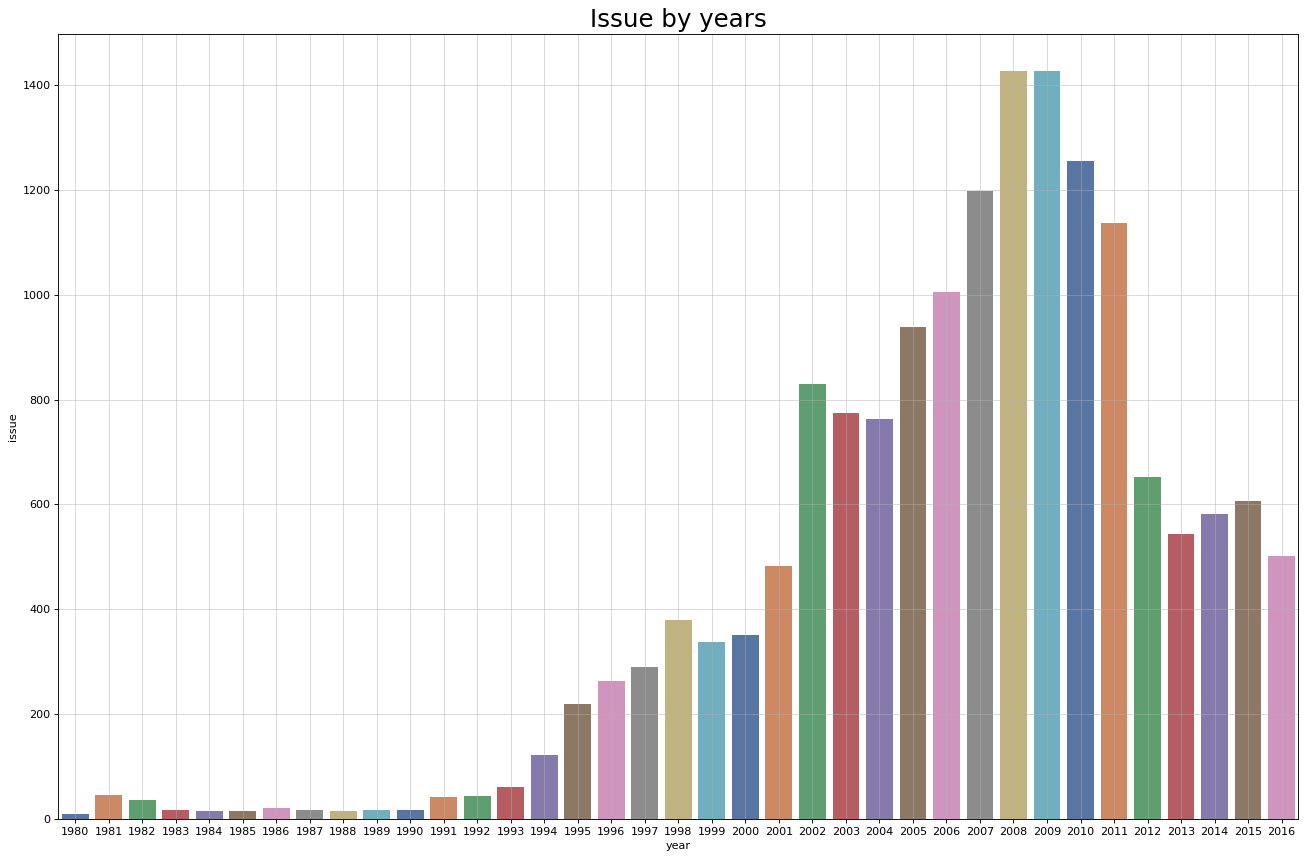

In [14]:
# Посмотрим, сколько игр выпускалось в разные годы
games['issue'] = 1
barplot = games.groupby('year')['issue'].sum().reset_index()

plt.figure(figsize=(20,13), dpi= 80)
sns.barplot(x='year', y='issue', palette="deep", data = barplot)
plt.title('Issue by years', fontsize=22)
plt.grid(alpha = 0.5)
plt.show()

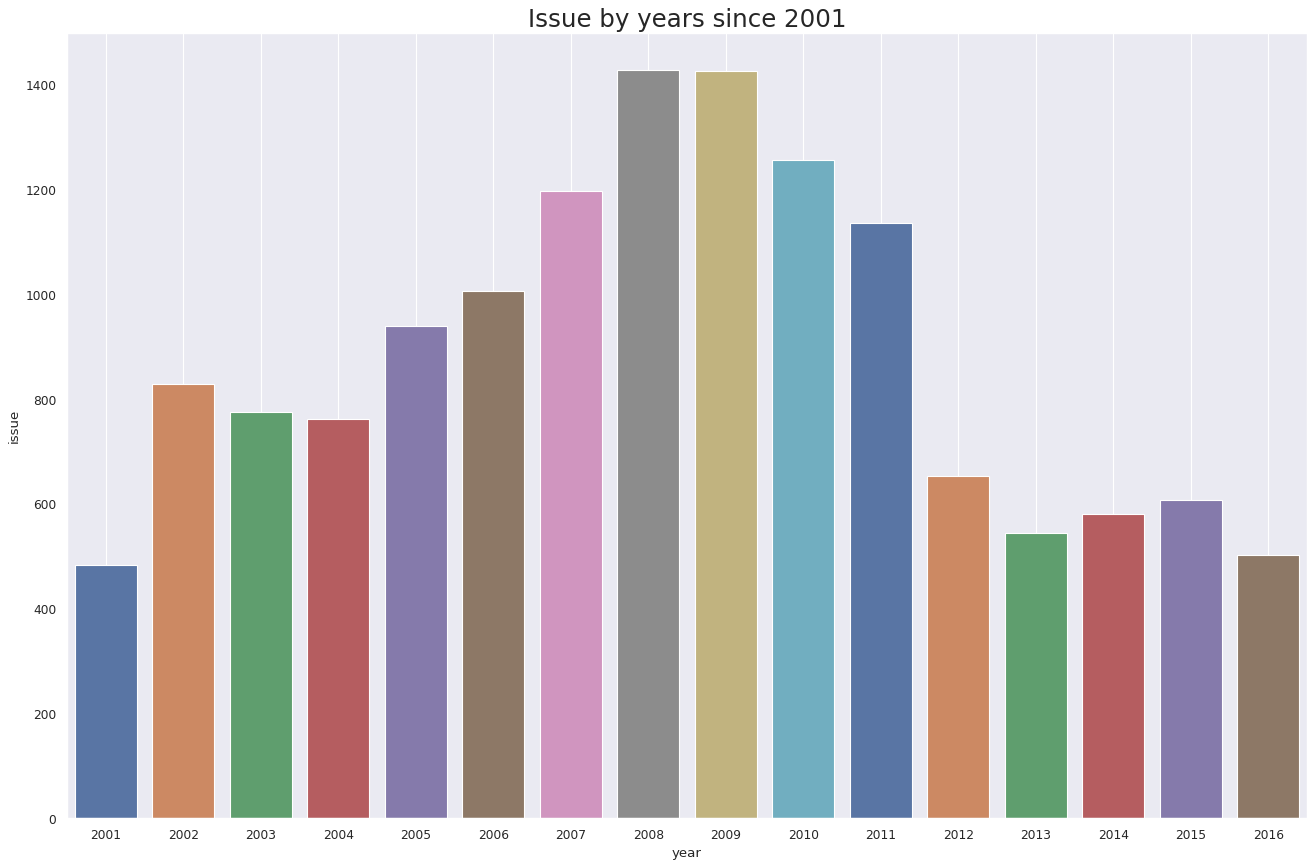

In [58]:
# На графике видно, что данные до 2001 года не так интересны, количество выпущенных игр в те времена было минимальным, а значит, не показательным. 
# Отфильтруем эти данные
games2001 = games.query('year >=2001')
barplot2001 = games2001.groupby('year')['issue'].sum().reset_index()

plt.figure(figsize=(20,13), dpi= 80)
sns.barplot(x='year', y='issue', palette="deep", data = barplot2001)
plt.title('Issue by years since 2001', fontsize=22)
plt.grid()
plt.show()

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

In [16]:
games2001.groupby('platform')['all_sales'].sum().sort_values(ascending = False).head(10).round()

platform
PS2     1194.0
X360     961.0
PS3      931.0
Wii      891.0
DS       803.0
PS4      314.0
GBA      313.0
PSP      290.0
3DS      258.0
XB       251.0
Name: all_sales, dtype: float64

Проведя анализ суммарных продаж платформ, выделим первые 5 ("PS2","X360","PS3","Wii","DS")

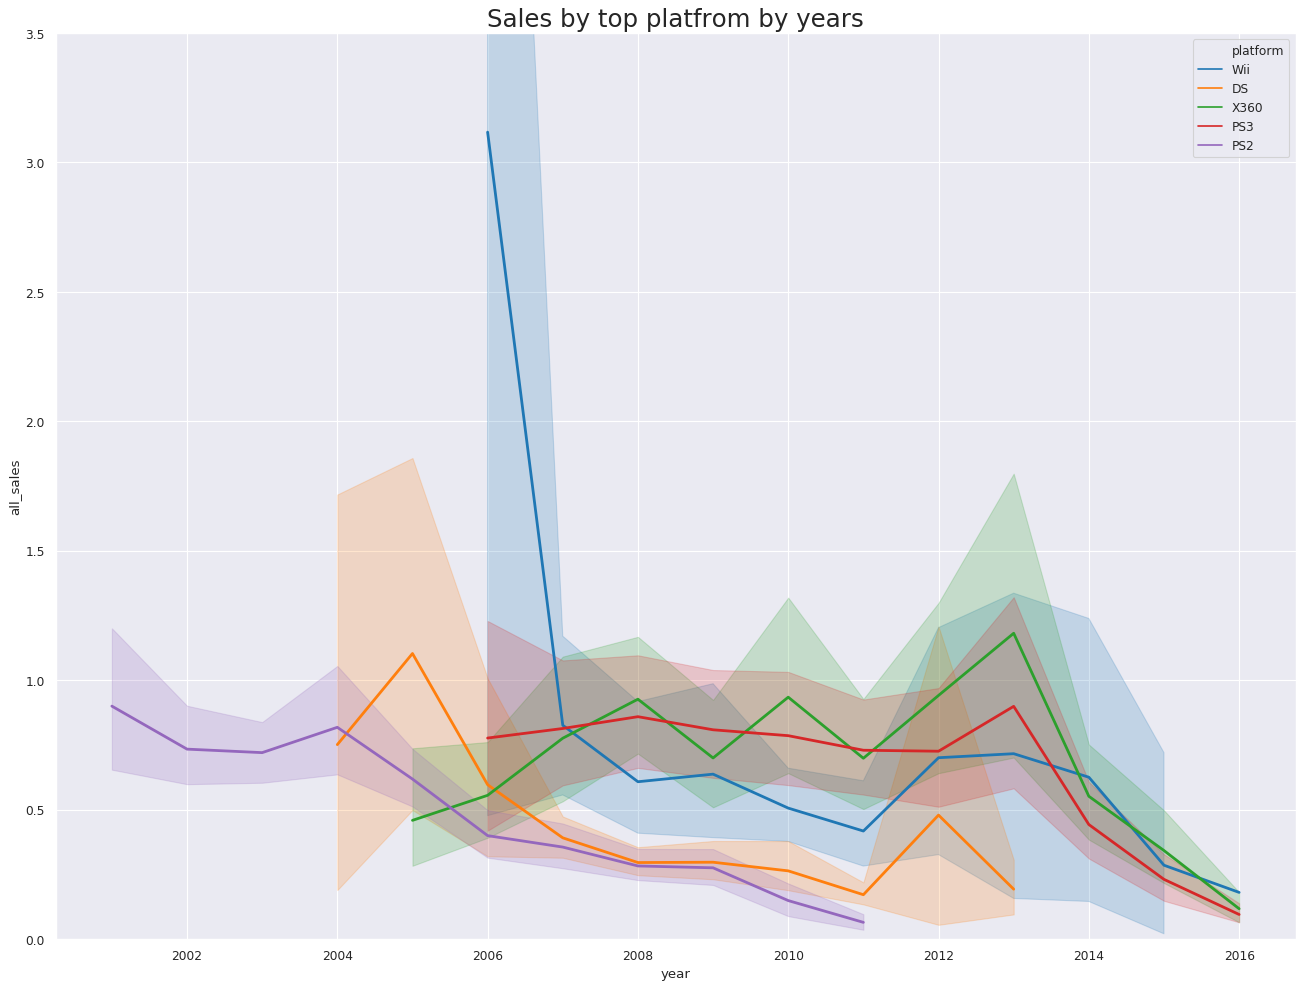

In [17]:
top_platform = games2001.query('platform in ("PS2","X360","PS3","Wii","DS")')

plt.figure(figsize=(20,15), dpi= 80)
sns.set(style="darkgrid")
sns.lineplot(x="year", y="all_sales",hue="platform",data=top_platform,palette="tab10", linewidth=2.5)
plt.title('Sales by top platfrom by years', fontsize=22)
plt.ylim(0, 3.5)
plt.show()

In [18]:
top_platform.groupby('platform')['year'].nunique()

platform
DS      10
PS2     11
PS3     11
Wii     11
X360    12
Name: year, dtype: int64

Исходя из графика и таблицы выше, видим, что в среднем новые платформы живут 11 лет (от 10 до 12 лет). Обычно выстреливают в первые годы и идут на спад к оканчанию жизненного цикла

**Возьмем данные за соответствующий актуальный период. Актуальный период определим самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.**

Актуальный период - последние 11 лет (отталкиваясь от среднего жизненного цикла платформы). С учетом того, что плнировать нам надо на год вперед, то будем брать данные с 2007 года и не будем брать 2016 год, так как он не полный, и может исказить анализ. Ну и в будущем, при планировании следующего года в конце текущего, текущей скорее всего не закрыт

In [59]:
# Уберем данные за предыдущие годы.
games2007 = games2001.query('year >= 2012')

In [20]:
# Выберем несколько потенциально прибыльных платформ
games2007.groupby('platform')['all_sales'].sum().sort_values(ascending = False).round()

platform
PS4     314.0
PS3     289.0
X360    237.0
3DS     195.0
XOne    159.0
WiiU     82.0
PC       63.0
PSV      49.0
Wii      35.0
DS       13.0
PSP      11.0
Name: all_sales, dtype: float64

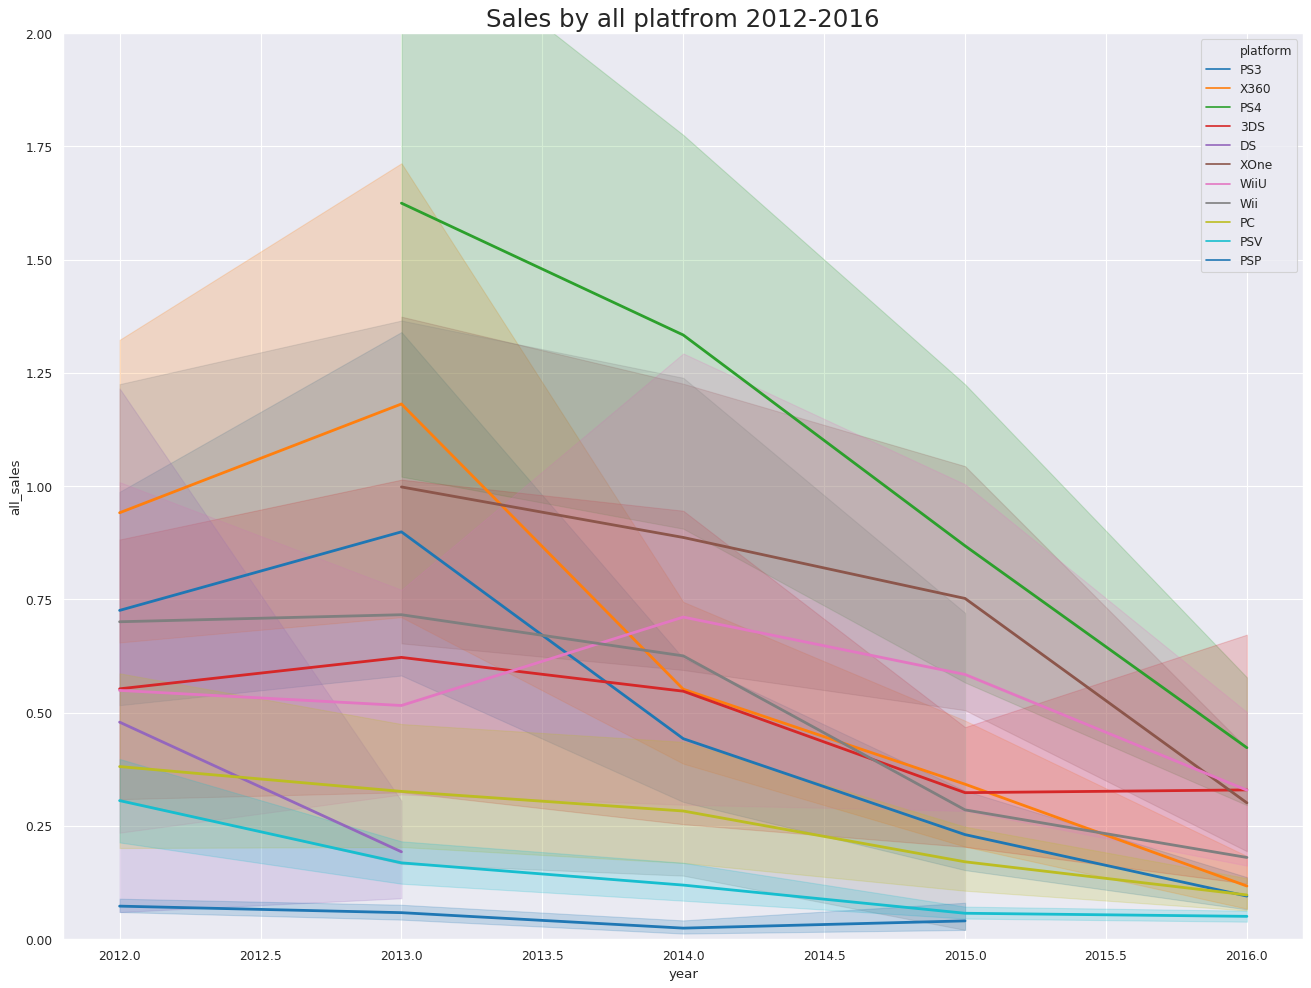

In [21]:
plt.figure(figsize=(20,15), dpi= 80)
sns.set(style="darkgrid")
sns.lineplot(x="year", y="all_sales",hue="platform",data=games2007,palette="tab10", linewidth=2.5)
plt.title('Sales by all platfrom 2012-2016', fontsize=22)
plt.ylim(0,2)
plt.show()

Жизненный цикл 4 лидеров ("X360","PS3","Wii","DS") - подходит к концу, в то время как ("PS4","XOne","3DS","WiiU") только в начале своего жизненного цикла, сделаем ставку на них

(0, 2)

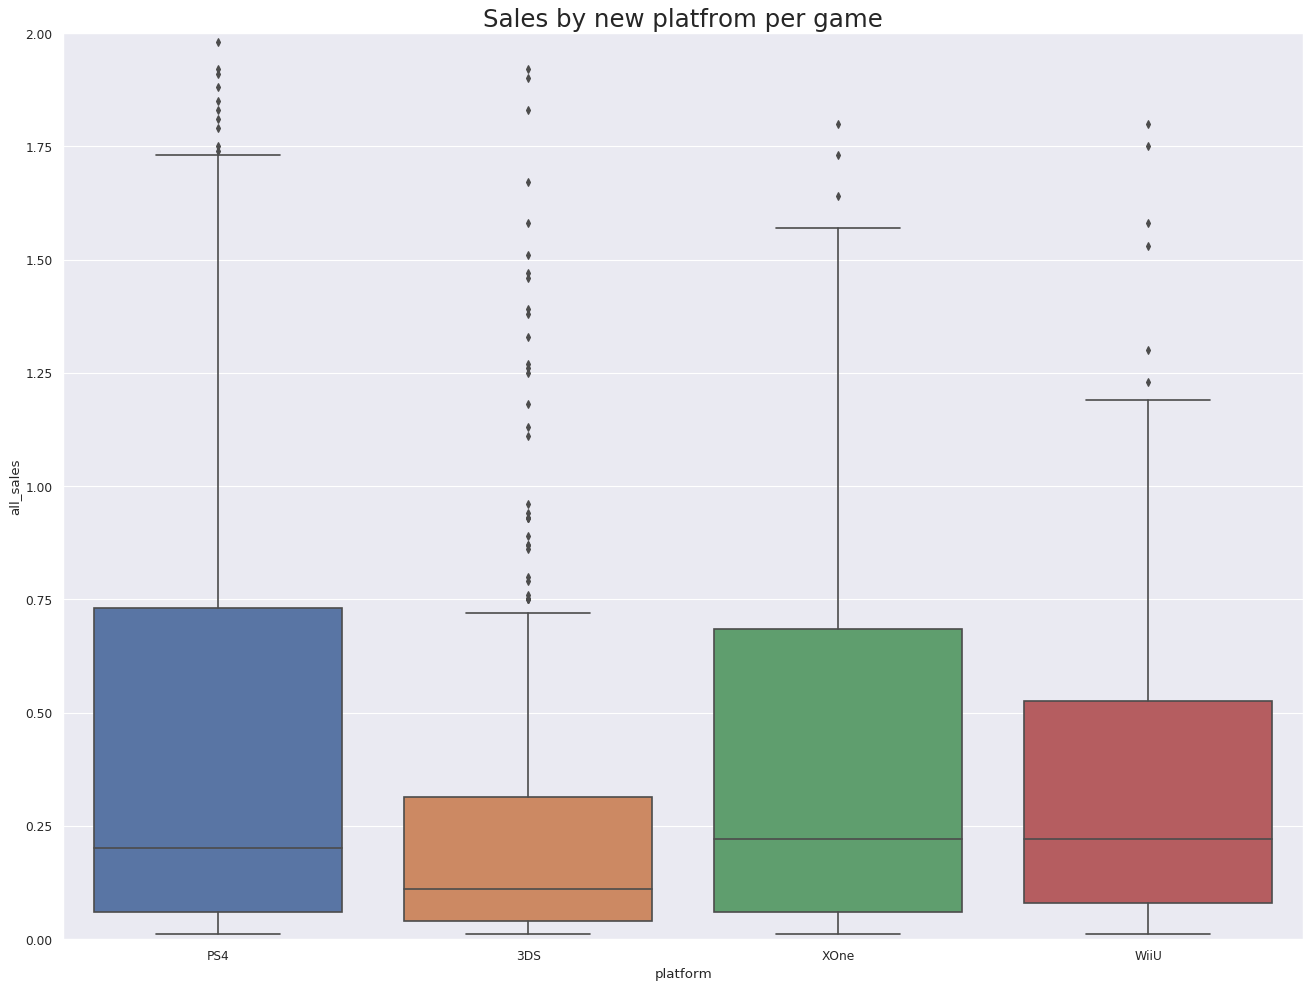

In [22]:
# Построим график  по глобальным продажам игр в разбивке по платформам.
new_platform = games2007.query('platform in ("PS4","XOne","3DS","WiiU")')

sns.set(style="darkgrid")
plt.figure(figsize=(20,15), dpi= 80)
sns.boxplot(x="platform", y="all_sales",data=new_platform)
plt.title('Sales by new platfrom per game', fontsize=22)
plt.ylim(0,2)

Медианные продажа игры на платформах "PS4", "XOne" и WiiU примерно одинакова (около 0,23 млн копий на игру). В то время, как платформa 3DS значительно отстает (0,1 млн копий на игру). Но, важно учесть, что имеется очень много выбросов у каждой платформы

**Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы.**

Text(0.5, 1.0, 'User score and critic score correlation PS3')

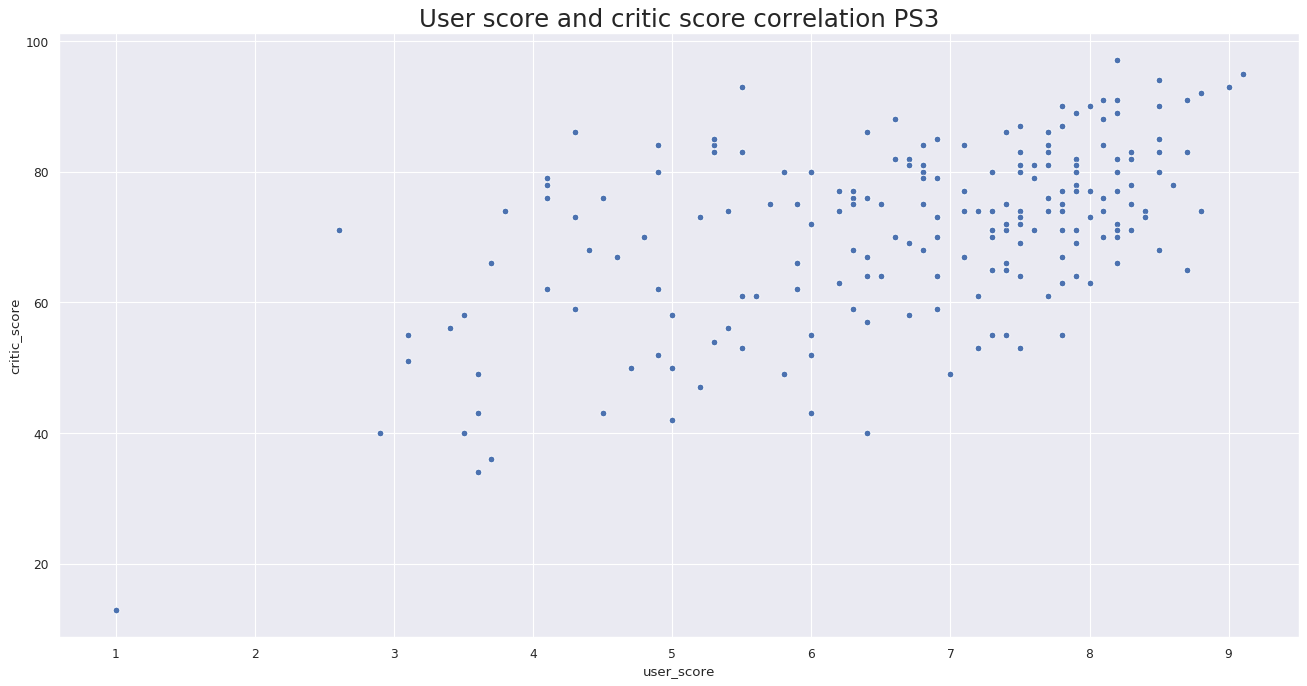

In [23]:
best_platform = games2007.query('platform == "PS3" and user_score != 0')

plt.figure(figsize=(20,10), dpi= 80)
sns.scatterplot(x="user_score", y="critic_score",data=best_platform)
plt.title('User score and critic score correlation PS3', fontsize=22)

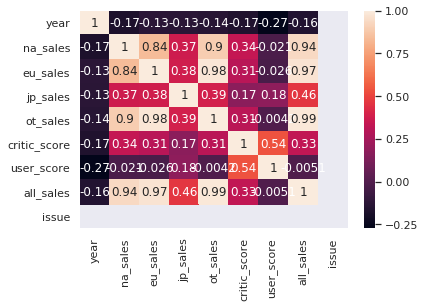

In [24]:
best_platform_corr_chart = best_platform.corr()
sns.heatmap(best_platform_corr_chart, annot=True)

На диаграме рассеяния мы видим, что оценки критиков и пользователей сильно взаимосвязаны 0,63

На графике с корреляцией мы видим, что на продажи сильнее влияют оценки критиков 0,43 против 0,12 оценки пользователей

**Соотнесем выводы с продажами игр на других платформах.**

Text(0.5, 1.0, 'User score and critic score correlation all platform')

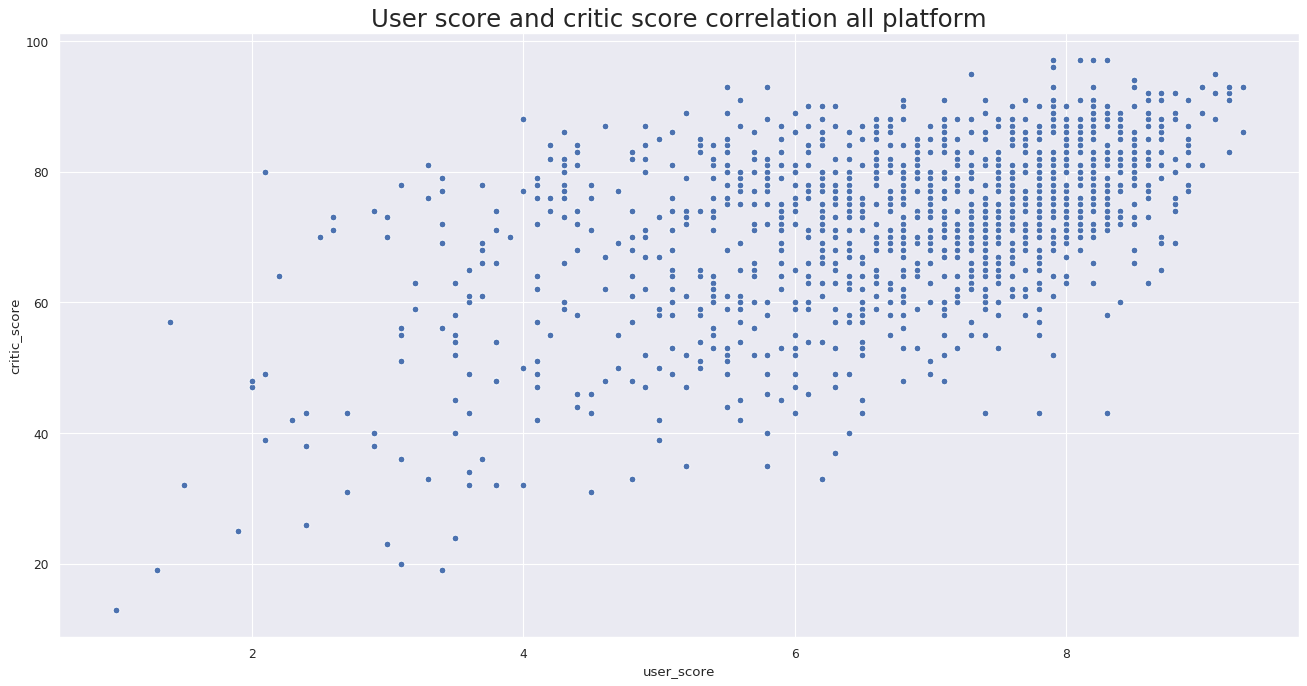

In [25]:
all_platform= games2007.query('user_score != 0')

plt.figure(figsize=(20,10), dpi= 80)
sns.scatterplot(x="user_score", y="critic_score",data=all_platform)
plt.title('User score and critic score correlation all platform', fontsize=22)

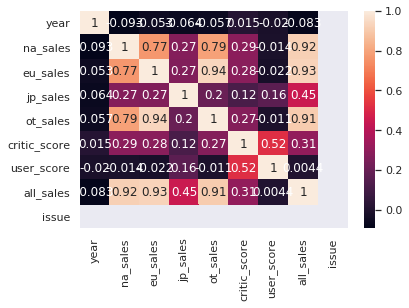

In [26]:
all_platform_corr_chart = all_platform.corr()
sns.heatmap(all_platform_corr_chart, annot=True)

На диаграме рассеяния по всем платформам мы видим, что оценки критиков и пользователей также взаимосвязаны, но слабее, чем по отдельной PS3 0,59 против 0,63

На графике с корреляцией мы видим, что на продажи на всех платформах все равно сильнее влияют оценки критиков 0,29 против 0,1 оценки пользователей, но зависимость значительно ниже, чем на PS3

**Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**

Text(0.5, 1.0, 'Sales by genres')

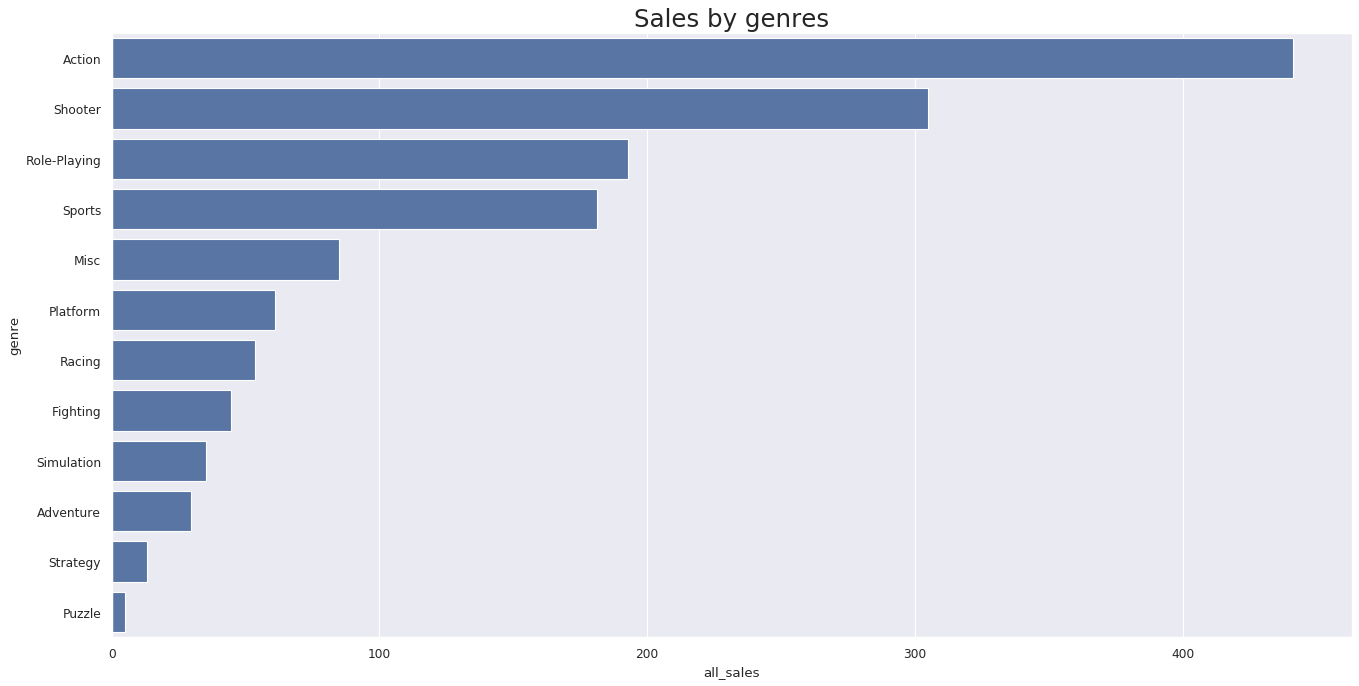

In [27]:
top_genre = games2007.groupby('genre')['all_sales'].sum().sort_values(ascending = False).reset_index()

plt.figure(figsize=(20,10), dpi= 80)
sns.barplot(x="all_sales", y="genre", data=top_genre, color="b")
plt.title('Sales by genres', fontsize=22)

Самые прибыльные жанры: Актиыне жанры, где не надо думать, направленные на моментальное удовлетворение потребностей в отдыхе:

Жанры с самыми низкими продажами: игры, где необходимо думать, планировать игру на несколько дней вперед и выстраивать стратегию

Итого: Люди хотят моментальных удовлетворений потребностей, прийти с работы или собраться с друзьями, выключить мозг и развлечься

In [28]:
games2007.groupby('genre')['all_sales'].agg(['sum','mean','median', 'count']).sort_values(by = 'count', ascending = False).head(5).reset_index()

,genre,sum,mean,median,count
0,Action,441.12,0.427856,0.12,1031
1,Role-Playing,192.80,0.521081,0.14,370
2,Adventure,29.43,0.097450,0.03,302
3,Sports,181.07,0.675634,0.24,268
4,Shooter,304.73,1.296723,0.44,235


In [29]:
games2007.groupby('genre')['all_sales'].agg(['sum','mean','median', 'count']).sort_values(by = 'median', ascending = False).head(5).reset_index()

,genre,sum,mean,median,count
0,Shooter,304.73,1.296723,0.44,235
1,Sports,181.07,0.675634,0.24,268
2,Platform,61.00,0.717647,0.21,85
3,Racing,53.50,0.465217,0.14,115
4,Role-Playing,192.80,0.521081,0.14,370


**Вывод**
* Сфера игра начала активно развиваться с 2001 года, когда количество выскаемых игр резко начало увеличиваться
* Самые продаваемые платформы с 2001 года "PS2","X360","PS3","Wii","DS"
* Средний жизненный цикл платформы составляет 11 лет
* Для прогнозирования следующего года используем последние 11 лет, не считая текущего года
* Потенциально прибыльные платформы в ближайшем времени "PS4","XOne","3DS","WiiU"
* Самые перспектиные из них "PS4","XOne" на них приходится самое большое количество копий на игру (медианное значение около 0.3 млн копий
* Есть тесная взаимосвязь между оценкой пользователей и критиков
* На уровень продаж сильнее влияет оценка критиков
* Самые популярные жанры - активные игры (аркады, шутеры и спорт)
* Самые невостребованные жанры - логические игры, головоломки
* Самый популярный жанр - Action (1031 игра)
* Самый востребованный жанр - Shooter (в среднем 0,44 М копий на игру

## Составление портрета пользователя каждого региона

### Регионы

In [30]:
# Выберем топ 5 в регионе Северная Америка и посчитаем долю продаж приходящихся на эти платформы
na_top = games2007.groupby('platform')['na_sales'].sum().sort_values(ascending = False).reset_index()
na_top['na_share'] = na_top['na_sales'] / na_top['na_sales'].sum()
na_top = na_top[['platform','na_share']].head(5).round(2)
na_top

,platform,na_share
0,X360,0.24
1,PS4,0.18
2,PS3,0.17
3,XOne,0.16
4,3DS,0.09


In [31]:
# Выберем топ 5 в регионе Европа и посчитаем долю продаж приходящихся на эти платформы
eu_top = games2007.groupby('platform')['eu_sales'].sum().sort_values(ascending = False).reset_index()
eu_top['eu_share'] = eu_top['eu_sales'] / eu_top['eu_sales'].sum()
eu_top = eu_top[['platform','eu_share']].head(5).round(2)
eu_top

,platform,eu_share
0,PS4,0.28
1,PS3,0.21
2,X360,0.15
3,XOne,0.10
4,3DS,0.08


In [32]:
# Выберем топ 5 в регионе Япония и посчитаем долю продаж приходящихся на эти платформы
jp_top = games2007.groupby('platform')['jp_sales'].sum().sort_values(ascending = False).reset_index()
jp_top['jp_share'] = jp_top['jp_sales'] / jp_top['jp_sales'].sum()
jp_top = jp_top[['platform','jp_share']].head(5).round(2)
jp_top

,platform,jp_share
0,3DS,0.46
1,PS3,0.18
2,PSV,0.11
3,PS4,0.08
4,WiiU,0.07


In [33]:
# Соберем все платформы в одну таблицу для возможности сравнения и отменим свертывание таблицы для возможности представления на одном графике
all_top=na_top.merge(eu_top, how = 'outer').merge(jp_top,how = 'outer')
all_top = all_top.groupby('platform').sum()
all_top = all_top.stack(-1).reset_index()
all_top.set_axis(['platform', 'region', 'sales'], axis='columns', inplace=True)

Text(0.5, 1, 'Top 5 platforms by region')

<Figure size 1600x800 with 0 Axes>

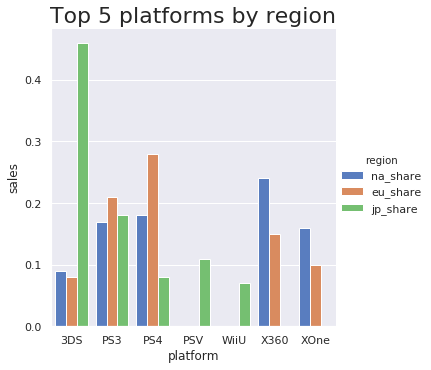

In [34]:
plt.figure(figsize=(20,10), dpi= 80)
sns.catplot(x="platform", y="sales", hue="region", data=all_top, kind="bar", palette="muted")
plt.title('Top 5 platforms by region', fontsize=22)

**Вывод**

Как мы можем видеть на графике в Европе и Америке популярностью больше пользуются мощные домашние приставки подходящие для больших экранов X360, PS3 и PS4, видно что в этих регионах приедпочитают играть в игры дома или у знакомых, в то время как в Японии большую популярность получили портативные приставки Nintendo 3DS, PSV, WiiU для возможности играть всегда и везде, например в общественном трансорте или местах. Похоже, что различия тесно связаны с разницей культур этих стран.

### Жанры

Делаем также как для регионов.

In [35]:
na_top_genre = games2007.groupby('genre')['na_sales'].sum().sort_values(ascending = False).reset_index()
na_top_genre['na_share'] = na_top_genre['na_sales'] / na_top_genre['na_sales'].sum()
na_top_genre = na_top_genre[['genre','na_share']].head(5).round(2)
na_top_genre

,genre,na_share
0,Action,0.30
1,Shooter,0.24
2,Sports,0.14
3,Role-Playing,0.11
4,Misc,0.06


In [36]:
eu_top_genre = games2007.groupby('genre')['eu_sales'].sum().sort_values(ascending = False).reset_index()
eu_top_genre['eu_share'] = eu_top_genre['eu_sales'] / eu_top_genre['eu_sales'].sum()
eu_top_genre = eu_top_genre[['genre','eu_share']].head(5).round(2)
eu_top_genre

,genre,eu_share
0,Action,0.31
1,Shooter,0.22
2,Sports,0.14
3,Role-Playing,0.10
4,Racing,0.05


In [37]:
jp_top_genre = games2007.groupby('genre')['jp_sales'].sum().sort_values(ascending = False).reset_index()
jp_top_genre['jp_share'] = jp_top_genre['jp_sales'] / jp_top_genre['jp_sales'].sum()
jp_top_genre = jp_top_genre[['genre','jp_share']].head(5).round(2)
jp_top_genre

,genre,jp_share
0,Role-Playing,0.34
1,Action,0.27
2,Misc,0.07
3,Simulation,0.05
4,Fighting,0.05


In [38]:
all_top_genre=na_top_genre.merge(eu_top_genre, how = 'outer').merge(jp_top_genre,how = 'outer')
all_top_genre = all_top_genre.groupby('genre').sum()
all_top_genre = all_top_genre.stack(-1).reset_index()
all_top_genre.set_axis(['genre', 'region', 'sales'], axis='columns', inplace=True)

Text(0.5, 1, 'Top 5 genres by region')

<Figure size 4000x2000 with 0 Axes>

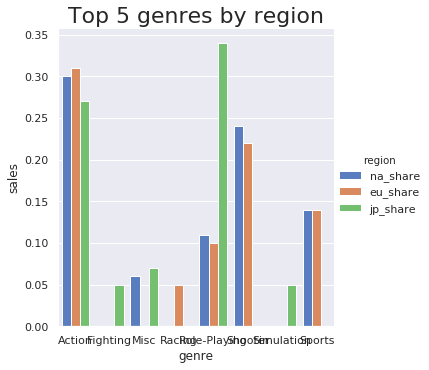

In [39]:
plt.figure(figsize=(20,10), dpi= 200)
sns.catplot(x="genre", y="sales", hue="region", data=all_top_genre, kind="bar", palette="muted")
plt.title('Top 5 genres by region', fontsize=22)

**Вывод**

И снова видим сходство между Америкой и Европой, где более популярны актиные жанры (шутеры, спорт, аркады). В то время как в японии абсолютное лидерство у игр жанра РПГ и вообще не популярны шутеры. Очевидно, что напрямую связано с поплуярностью платформ в своих регионах, правда не понятно, жанры зависят от приставок, или наоборот, приставки выбирают из своих предпочтений. Анализ самых популярных жанров снова показывает на огромную разницу в культуре этих регионов

### Влияние  рейтинга ESRB на продажи в отдельном регионе

In [40]:
# уберем из выборки все данные, где рейтинг не заполнен
games_notna = games2007.query('rating.notna()')

In [41]:
# выберем топ 4 (так как на 4 категории приходится 100% продаж) возрастные категории в регионе Северная Америка и посчитаем долю продаж приходящихся на эти возрастные категории
na_top_rating = games_notna.groupby('rating')['na_sales'].sum().sort_values(ascending = False).reset_index()
na_top_rating['na_share'] = na_top_rating['na_sales'] / na_top_rating['na_sales'].sum()
na_top_rating = na_top_rating[['rating','na_share']].head(5).round(2)
na_top_rating

,rating,na_share
0,M,0.47
1,E,0.23
2,E10+,0.16
3,T,0.14


In [42]:
# выберем топ 4 (так как на 4 категории приходится 100% продаж) возрастные категории в регионе Европа и посчитаем долю продаж приходящихся на эти возрастные категории
eu_top_rating = games_notna.groupby('rating')['eu_sales'].sum().sort_values(ascending = False).reset_index()
eu_top_rating['eu_share'] = eu_top_rating['eu_sales'] / eu_top_rating['eu_sales'].sum()
eu_top_rating = eu_top_rating[['rating','eu_share']].head(5).round(2)
eu_top_rating

,rating,eu_share
0,M,0.47
1,E,0.27
2,E10+,0.13
3,T,0.13


In [43]:
# Выберем топ 4 (так как на 4 категории приходится 100% продаж) возрастные категории в регионе Япония и посчитаем долю продаж приходящихся на эти возрастные категории
jp_top_rating = games_notna.groupby('rating')['jp_sales'].sum().sort_values(ascending = False).reset_index()
jp_top_rating['jp_share'] = jp_top_rating['jp_sales'] / jp_top_rating['jp_sales'].sum()
jp_top_rating = jp_top_rating[['rating','jp_share']].head(5).round(2)
jp_top_rating

,rating,jp_share
0,E,0.34
1,T,0.31
2,M,0.25
3,E10+,0.10


In [44]:
all_top_rating=na_top_rating.merge(eu_top_rating, how = 'outer').merge(jp_top_rating,how = 'outer')
all_top_rating = all_top_rating.groupby('rating').sum()
all_top_rating = all_top_rating.stack(-1).reset_index()
all_top_rating.set_axis(['rating', 'region', 'sales'], axis='columns', inplace=True)

Text(0.5, 1, 'Top 5 ratings by region')

<Figure size 1600x800 with 0 Axes>

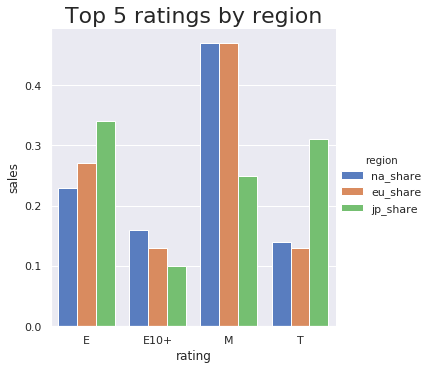

In [45]:
plt.figure(figsize=(20,10), dpi= 80)
sns.catplot(x="rating", y="sales", hue="region", data=all_top_rating, kind="bar", palette="muted")
plt.title('Top 5 ratings by region', fontsize=22)

Краткое описание категорий:
* «E» («Everyone») — «Для всех»: Содержание вполне подходит для возрастной категории от 6 лет и старше; такие игры могут понравиться и взрослым. Игры с этим рейтингом могут содержать минимальное насилие, в основном «мультяшного» характера

* «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»: Проекты с данным рейтингом могут содержать немного больше мультипликационного или мягкого насилия, или несколько откровенные сцены или минимальное количество крови.

* «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет и старше. Проекты из данной категории могут содержать насилие, непристойные сцены, грубый юмор, в меру откровенное сексуальное содержимое, кровь или нечастое использование ненормативной лексики.

* «M» («Mature») — «Для взрослых»: Материалы игры не подходят для подростков младше 17 лет. Проекты с данным рейтингом могут содержать достаточно жестокое насилие, большое количество крови с расчленением, непристойные сексуальные сцены или грубую ненормативную лексику, нежелательную для младшей аудитории.

**Вывод**

На графике снова можем видеть сходство между Европой и Америкой, там лидирует категория «M» - игры для взрослых, в то время, как в Японии эта категория занимает лишь 3ее место, а лидер - «E» игры для всех.

На втором месте в регионах Е и СА - «E» игры для всех, в то время, как для Японии игры для подростков
Последнее место во всех регионах занимает категория «E10+» - Для всех от 10 лет и старше, видимо это связано с тем, что аудитория уэтой категории очень узкая.

В целом, можем наблюдать сходство между Европой и Северной Америкой, и как сильно отличается аудитория в Японии

## Проверка гипотез

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC не отличаются

Алтернативаная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC различны

In [46]:
hypo1 = games2007.query('user_score.notna() and user_score !=0 and (platform == "XOne" or platform == "PC")')

In [47]:
hypo1.groupby('platform')['user_score'].agg(['mean','count']).round().reset_index()

,platform,mean,count
0,PC,6.0,206
1,XOne,7.0,182


In [48]:
xone = hypo1.query('platform == "XOne"')['user_score']
pc = hypo1.query('platform == "PC"')['user_score']

In [49]:
alpha = 0.05

In [60]:
results = st.ttest_ind(xone, pc)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


**Вывод**

P.value - очень высокий, это значит получить такую разницу между средними оценками пользователей разных платформ случайно составляет около 55%, у нас не получилось отвергнуть нулевую гипотезу - средние пользовательские рейтинги платформ Xbox One и PC вероятно не различаются

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports не отличаются

Алтернативаная гипотеза: средние пользовательские рейтинги жанров Action и Sports различны

In [51]:
hypo2 = games2007.query('user_score.notna() and user_score !=0 and (genre == "Action" or genre == "Sports")')

In [52]:
hypo2.groupby('genre')['user_score'].agg(['mean','count']).round().reset_index()

,genre,mean,count
0,Action,7.0,523
1,Sports,5.0,195


In [53]:
action = hypo2.query('genre == "Action"')['user_score']
sports = hypo2.query('genre == "Sports"')['user_score']

In [54]:
alpha = 0.05

In [55]:
results = st.ttest_ind(action, sports)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


**Вывод**

P.value - очень низкий, это значит получить такую разницу между средними оценками пользователей разных жанров случайно практически невозможен, у нас есть основания отбросить нулевую гипотезу - средние пользовательские рейтинги жанров Action и Sports различны

## Общий вывод

In [56]:
games.groupby('platform')['all_sales'].sum().sort_values(ascending= False).head(5)

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
Name: all_sales, dtype: float64

In [57]:
games.groupby('genre')['all_sales'].sum().sort_values(ascending= False).head(5)

genre
Action          1716.52
Sports          1309.67
Shooter         1041.36
Role-Playing     931.08
Platform         825.55
Name: all_sales, dtype: float64

**Вывод**

Принцип работы с данными:
* Берем данные за последние 5 лет (жизненный цикл продукта / 2)
* Выбираем, какой регион будем прогнозировать
* Далее смотрим на определяющие успешность игры закономерности:
1. Платформа, на которой вышла игра
* Для Европы и Америки лучшими платформами являются домашние платформы: X360,XOne,PS3,PS4
* Для Японии больше портативные платформы: 3DS, PSV, PS3, PS4, WiiU
2. Жанр игры

* Для Европы и Америки лучшими жанрами являются актиные игры: Action,Shooter,Sports,Misc,Role-Playing, скорее всего это связано с тем, что жители этих регионов предпочитают играть дома или у друзей

* В то время как в Японии самым популярным жанром является РПГ, а потом уже активные жанры: Role-Playing, Action,Misc,Sports,Platform, скорее всего это связано с преобладающим количеством переносных платформ, в которые удобно играть в любом месте

3. Категория игры
* На графике снова можем видеть сходство между Европой и Америкой, там лидирует категория «M» - игры для взрослых, в то время, как в Японии эта категория занимает лишь 3ее место, а лидер - «E» игры для всех
* Последнее место во всех регионах занимает категория «E10+» - Для всех от 10 лет и старше